In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cullen_frey_giovanni import cullenfrey
from mfdfa_ss_m1 import getHurstByUpscaling
from mfdfa_ss_m2 import getMSSByUpscaling
from mfdfa_ss_m3 import getScalingExponents
from scipy.stats import norm, genextreme
from sklearn.preprocessing import MinMaxScaler

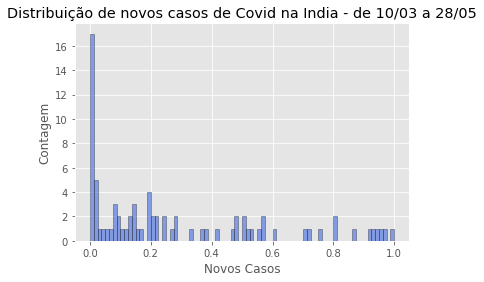

<Figure size 800x800 with 0 Axes>

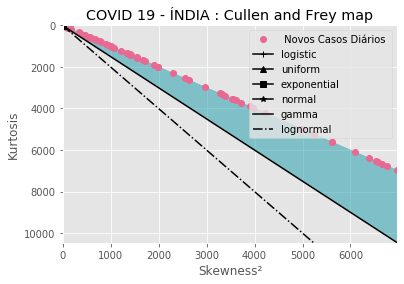

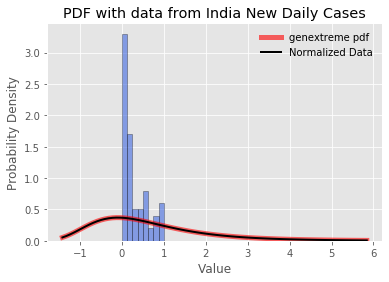

alpha_min = 0.652612, alpha_max = 1.74642, dalpha = 1.09381
h_min = 0.621303, h_max = 1.80988, dh = 1.18858



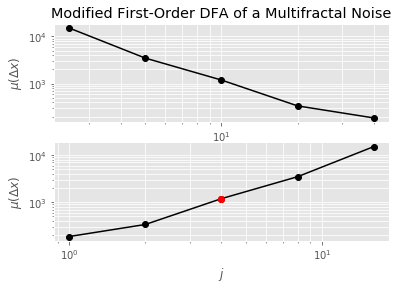

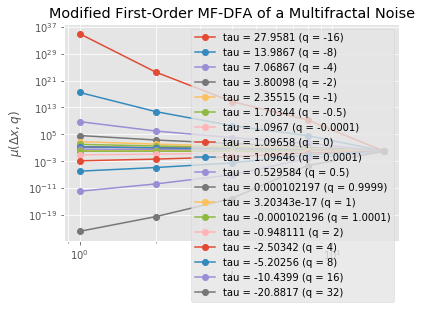

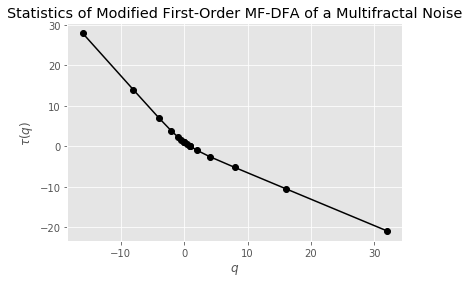

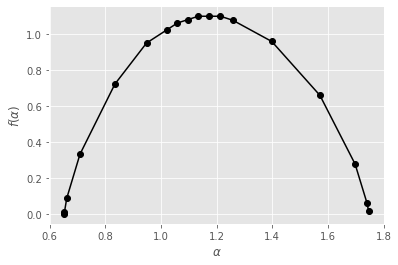

        Alfa      Beta  Assimetria de Alfa    Alfa 0  Delta Alfa
0   1.746424  2.492848            1.927095  1.372739    1.093812
1   1.740788  2.481576            1.927095  1.372739    1.093812
2   1.697626  2.395252            1.927095  1.372739    1.093812
3   1.571173  2.142346            1.927095  1.372739    1.093812
4   1.398361  1.796721            1.927095  1.372739    1.093812
5   1.258584  1.517168            1.927095  1.372739    1.093812
6   1.213730  1.427459            1.927095  1.372739    1.093812
7   1.172481  1.344963            1.927095  1.372739    1.093812
8   1.133989  1.267978            1.927095  1.372739    1.093812
9   1.096578  1.193157            1.927095  1.372739    1.093812
10  1.059168  1.118336            1.927095  1.372739    1.093812
11  1.021966  1.043931            1.927095  1.372739    1.093812
12  0.948111  0.896221            1.927095  1.372739    1.093812
13  0.834467  0.668934            1.927095  1.372739    1.093812
14  0.709075  0.418150   

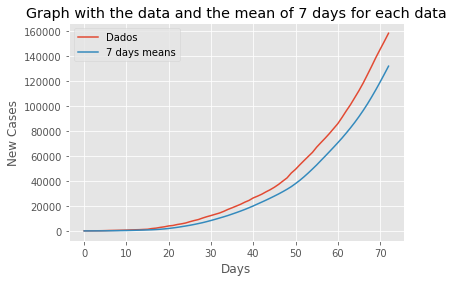

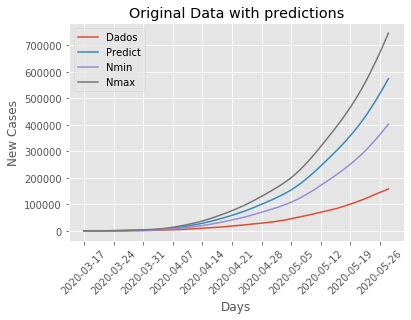

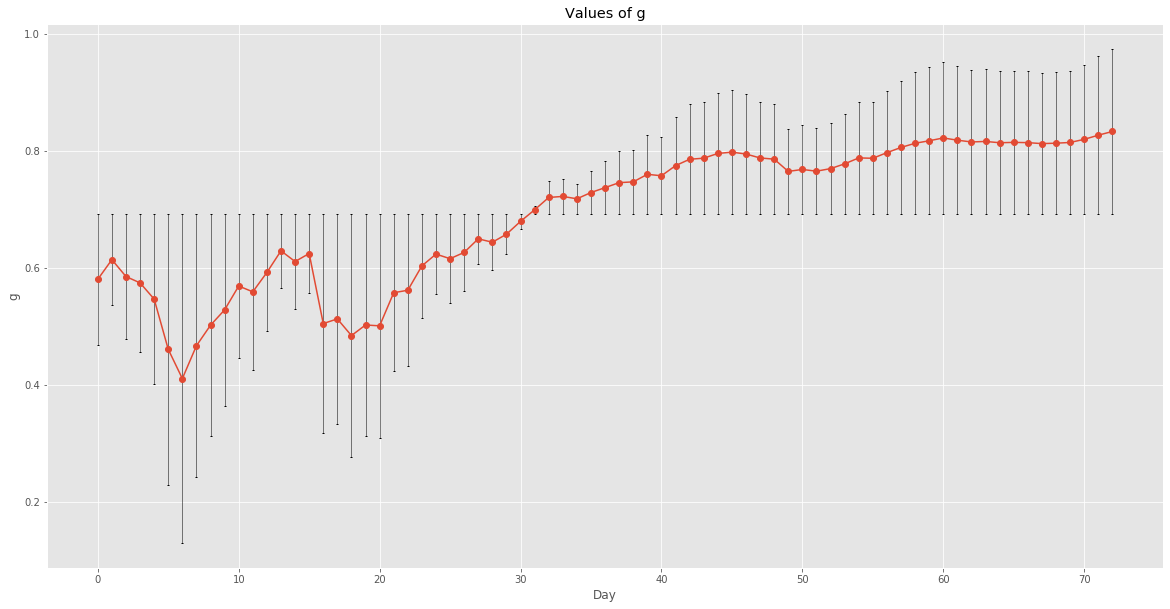

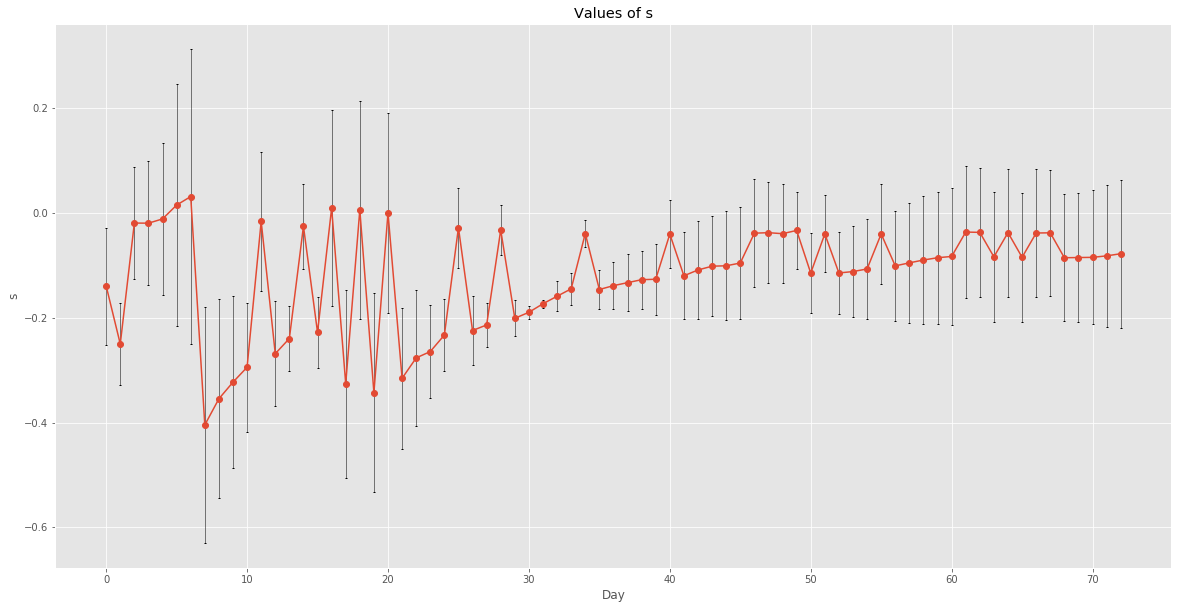

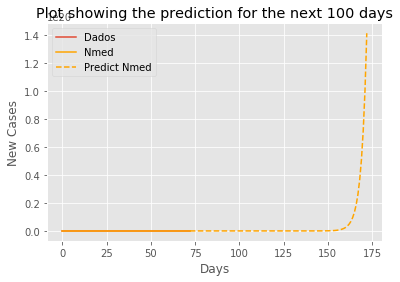

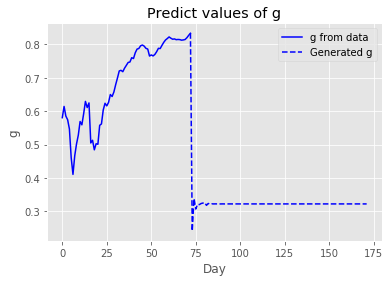

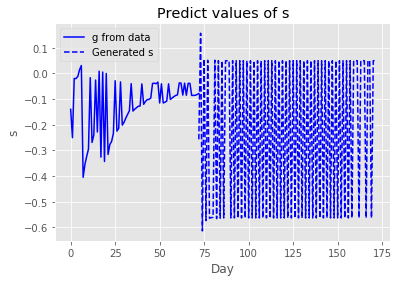

In [9]:
def criarDataSet():
    url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
    df = pd.read_csv(url, index_col=0)
    data = df.query('location == "India" & date >= "2020-03-10" & date <= "2020-05-28"').replace(np.nan, 0)
    data.to_csv('nd_covid_India.csv', index=False, header=True)
    return data

############################################################################################ BRANCH ESQUERDO


############################################################################################ PLOT 1 - HISTOGRAMA

def plotarHistograma(data):
    #Plota um histograma que separa os dados de acordo com os 80 pontos
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(pd.DataFrame(data['new_cases']))
    scaled_data = pd.DataFrame(scaled_data)
    
    scaled_data.hist(bins = 80, ec = "k", alpha = .6, color = "royalblue")
    
    plt.title('Distribuição de novos casos de Covid na India - de 10/03 a 28/05')
    plt.xlabel('Novos Casos')
    plt.ylabel('Contagem')
    plt.savefig('Histograma/Histograma dos Novos Casos COVID 19 - India.png')
    plt.show()

############################################################################################ PLOT 2 - PDF
    
def plotPDF(dadoPais):        
    NDCIndia =  dadoPais['new_cases'].values
    fig, ax = plt.subplots(1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))

    scaled_data = scaler.fit_transform(pd.DataFrame(NDCIndia))
    c = -0.1
    mean, var, skew, kurt = genextreme.stats(c, moments='mvsk')
    x = np.linspace(genextreme.ppf(0.01, c), genextreme.ppf(0.99, c), len(scaled_data))

    plt.style.use("ggplot")
    ax.plot(x, genextreme.pdf(x, c),'r-', lw=5, alpha=0.6, label='genextreme pdf')

    rv = genextreme(c)
    ax.plot(x, rv.pdf(x), 'k-', lw=2, label='Normalized Data')

    vals = genextreme.ppf([0.001, 0.5, 0.999], c)
    resp = np.allclose([0.001, 0.5, 0.999], genextreme.cdf(vals, c))
    r = genextreme.pdf(c, scaled_data)

    plt.title("PDF with data from India New Daily Cases")
    ax.hist(scaled_data, bins='auto', ec="k", density=True, alpha=0.6, color='royalblue')
    ax.legend(loc='best', frameon=False)
    plt.xlabel('Value')
    plt.ylabel('Probability Density')
    plt.savefig('PDF/PDFIndia New Daily Cases.png')
    plt.show()

############################################################################################ PLOT 4 e 5 - DFA

def plotarDFA(dado):
    url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
    df = pd.read_csv(url, index_col=0)
    data = df.query('location == "India" & date >= "2020-03-10" & date <= "2020-05-28"').replace(np.nan, 0)
    data.to_csv('nd_covid_India.csv', index=False, header=True)
    dx = data['new_cases'].values.tolist()            # We take the first 8192 samples
    
    country = 'India'
    
    ## Computing
    # Modified first-order DFA
    [timeMeasure, meanDataMeasure, scales] = getHurstByUpscaling(dx)                    # Set of parameters No. 1
    #[timeMeasure, meanDataMeasure, scales] = getHurstByUpscaling(dx, 3.0, 0, 2.0)       # Set of parameters No. 2

    [bScale, bDM, bsIndex, HMajor, HMinor] = getScalingExponents(timeMeasure, meanDataMeasure)

    # Modified first-order MF-DFA
    [_, dataMeasure, _, stats, q] = getMSSByUpscaling(dx, isNormalised = 1)

    ## Output
    # Modified first-order DFA
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.loglog(timeMeasure, meanDataMeasure, 'ko-')
    plt.xlabel(r'$\mu(t)$')
    plt.ylabel(r'$\mu(\Delta x)$')
    plt.grid('on', which = 'minor')
    plt.title('Modified First-Order DFA of a Multifractal Noise')


    plt.subplot(2, 1, 2)
    plt.loglog(scales, meanDataMeasure, 'ko-')
    plt.loglog(bScale, bDM, 'ro')
    plt.xlabel(r'$j$')
    plt.ylabel(r'$\mu(\Delta x)$')
    plt.grid('on', which = 'minor')


    # Modified first-order MF-DFA
    print('alpha_min = %g, alpha_max = %g, dalpha = %g' % (stats['LH_min'], stats['LH_max'], stats['LH_max'] - stats['LH_min']))
    print('h_min = %g, h_max = %g, dh = %g\n' % (stats['h_min'], stats['h_max'], stats['h_max'] - stats['h_min']))

    plt.savefig('DFA/Modified First-Order DFA of a Multifractal Noise')
    plt.figure()
    nq = np.int(len(q))
    leg_txt = []
    for qi in range(1, nq + 1):
        llh = plt.loglog(scales, dataMeasure[qi - 1, :], 'o-')
        leg_txt.append('tau = %g (q = %g)' % (stats['tau'][qi - 1], q[qi - 1]))
    plt.xlabel(r'$j$')
    plt.ylabel(r'$\mu(\Delta x, q)$')
    plt.grid('on', which = 'minor')
    plt.title('Modified First-Order MF-DFA of a Multifractal Noise')
    plt.savefig('DFA/Modified First-Order MF-DFA of a Multifractal Noise')
    plt.legend(leg_txt)

    plt.figure()

    #plt.subplot(2, 1, 1)
    plt.plot(q, stats['tau'], 'ko-')
    plt.xlabel(r'$q$')
    plt.ylabel(r'$\tau(q)$')
    plt.grid('on', which = 'major')
    plt.title('Statistics of Modified First-Order MF-DFA of a Multifractal Noise')

    plt.savefig('DFA/Statistics of Modified First-Order MF-DFA of a Multifractal Noise(tal)')
    plt.figure()

    #plt.subplot(2, 1, 2)
    plt.plot(stats['LH'], stats['f'], 'ko-')
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$f(\alpha)$')
    plt.grid('on', which = 'major')

    plt.savefig('DFA/Statistics of Modified First-Order MF-DFA of a Multifractal Noise(alfa)')
    plt.show()

    beta = 2.*stats['LH']-1.
    alfaZero = stats['LH_max']-stats['LH_min']/stats['LH_max']
    AssimetryAlfa = (alfaZero - stats['LH_min'])/(stats['LH_max'] - alfaZero) 

    table = pd.DataFrame(data=stats['LH'], columns=['Alfa'])
    table.insert(loc=1, column='Beta', value=beta)
    table.insert(loc=2, column='Delta Alfa', value=stats['LH_max'] - stats['LH_min'])
    table.insert(loc=2, column='Alfa 0', value=alfaZero)
    table.insert(loc=2, column='Assimetria de Alfa', value=AssimetryAlfa)
    
    print(table)


############################################################################################ BRANCH DIREITO    

def calculateGandSCurve(dado):
    p = [[0.5, 0.45, 0.05], [0.7, 0.25, 0.05]]
    pind = 0
    vals = [[1, 3, 5], [2, 4, 6]]

    y = dado['total_cases'].values.tolist()
    date = dado['date'].values.tolist()
    country = "India"

    # Quantidade de dias que serão usados
    meandays = 7


    Nmin = []  
    Nmax = []  
    Nguess = []  
    Nk7 = []  
    g = []  
    deltank = []  

    xticks = []
    for i in range(meandays, len(date)):
        if i % meandays == 0:
            xticks.append(date[i])

    for i in range(meandays, len(y)):
        Nk7.append((sum(y[i-meandays:i]))/meandays)
        if y[i] < Nk7[-1]:
            g.append(y[i]/Nk7[-1])
        else:
            g.append(Nk7[-1]/y[i])
        n = np.dot(p[pind], y[i])
        Nmin.append(g[-1]*np.dot(n, vals[0]))
        Nmax.append(g[-1]*np.dot(n, vals[1]))
        Nguess.append((Nmin[-1]+Nmax[-1])/2)
        if(y[i]!=0):
            deltank.append((Nk7[-1]-y[i])/y[i])
        else:
            deltank.append(np.nan)


    # Calculating deltag to calculate s and plot
    deltag = [0]
    for i in range(1, len(g)):
        g0 = g[i-1]
        if g0 < g[i]:
            deltag.append(g0-g[i] - (1-g[i])**2)
        else:
            deltag.append(g0-g[i] + (1-g0)**2)

    deltag = np.array(deltag)
    deltank = np.array(deltank)
    s = (2*deltag + deltank)/3


    # Plotando as variáveis Nmin, Nmax, Nguess com os dados originais

    plt.title("Graph with the data and the mean of 7 days for each data")
    plt.ylabel("New Cases")
    plt.xlabel("Days")
    plt.plot(range(len(y)-meandays), y[meandays:], label="Dados")
    plt.plot(range(len(Nk7)), Nk7, label="{} days means".format(meandays))
    plt.legend()
    plt.savefig("CurvaGeS/{}meananddata.png".format("India, "))
    plt.show()


    plt.title("Original Data with predictions")
    plt.ylabel("New Cases")
    plt.xlabel("Days")
    plt.plot(range(len(y)-meandays), y[meandays:], label="Dados")
    plt.plot(range(len(Nguess)), Nguess, label="Predict")
    plt.xticks(np.arange(80, step=meandays), xticks, rotation=45)
    plt.plot(range(len(Nmin)), Nmin, label="Nmin")
    plt.plot(range(len(Nmax)), Nmax, label="Nmax")
    plt.legend()
    plt.savefig("CurvaGeS/{}originaldata.png".format("India, "))
    plt.show()

    # Plotando os valores calculados para g

    g = np.array(g)
    plt.figure(figsize=(20, 10))
    meang = abs(sum(g)/len(g)-g)
    plt.title("Values of g")
    plt.xlabel("Day")
    plt.ylabel("g")
    plt.errorbar(range(len(g)), g, yerr=meang, xerr=0, hold=True, ecolor='k',
                 fmt='none', label='data', elinewidth=0.5, capsize=1)
    plt.plot(range(len(g)), g, 'o-')
    plt.savefig("CurvaGeS/{}originalg.png".format("India, "))
    plt.show()

    # Plotando os valores calculados para s

    s = np.array(s)
    plt.figure(figsize=(20, 10))
    means = abs(sum(s)/len(s)-s)
    plt.title("Values of s")
    plt.xlabel("Day")
    plt.ylabel("s")
    plt.errorbar(range(len(s)), s, yerr=meang, xerr=0, hold=True, ecolor='k', fmt='none', label='data', elinewidth=0.5, capsize=1)
    plt.plot(range(len(s)), s, 'o-')
    plt.savefig("CurvaGeS/{}originals.png".format("India, "))
    plt.show()

    # Previsão a partir dos dados originais

    preddays = 100  
    predictNmin = [Nmin[-1]]
    predictNmax = [Nmax[-1]]
    predictg = []
    predictNmed = y[-meandays-1:]
    predictNk7 = []
    predictdeltank = []
    for i in range(meandays, preddays+meandays):
        predictNk7.append(sum(predictNmed[i-meandays:i])/meandays)
        if predictNmed[i] < predictNk7[-1]:
            predictg.append(predictNmed[i]/predictNk7[-1])
        else:
            predictg.append(predictNk7[-1]/predictNmed[i])
        n = np.dot(p[pind], predictNmed[-1])
        predictNmin.append(predictg[-1]*np.dot(n, vals[0]))
        predictNmax.append(predictg[-1]*np.dot(n, vals[1]))
        predictNmed.append((predictNmin[-1]+predictNmax[-1])/2)
        predictdeltank.append((predictNk7[-1]-predictNmed[-1])/predictNmed[-1])

    plt.title("Plot showing the prediction for the next {} days".format(preddays))
    plt.ylabel("New Cases")
    plt.xlabel("Days")
    plt.plot(range(len(y)-meandays), y[meandays:], label="Dados")
    plt.plot(range(len(Nguess)), Nguess, label="Nmed", c="orange")
    plt.plot(range(len(y)-meandays-1, len(y)+preddays-meandays),
             predictNmed[meandays:], c="orange", linestyle='--',
             label="Predict Nmed")
    plt.legend()
    plt.savefig("CurvaGeS/{}predictmeananddata.png".format(country+", "))
    plt.show()

    plt.title("Predict values of g")
    plt.xlabel("Day")
    plt.ylabel("g")
    plt.plot(range(len(g)), g, c="b", label="g from data")
    plt.plot(range(len(g)-1, len(g)+preddays-1), predictg, c="b", linestyle='--', label="Generated g")
    plt.legend()
    plt.savefig("CurvaGeS/{}predictg.png".format("India, "))
    plt.show()

    predictdeltag = [0]
    for i in range(1, len(predictg)):
        g0 = predictg[i-1]
        if g0 < predictg[i]:
            predictdeltag.append(g0-predictg[i] - (1-predictg[i])**2)
        else:
            predictdeltag.append(g0-predictg[i] + (1-g0)**2)

    predictdeltag = np.array(predictdeltag)
    predictdeltank = np.array(predictdeltank)
    predicts = (2*predictdeltag + predictdeltank)/3

    plt.title("Predict values of s")
    plt.xlabel("Day")
    plt.ylabel("s")
    plt.plot(range(len(s)), s, c="b", label="g from data")
    plt.plot(range(len(s)-1, len(s)+preddays-1), predicts, c="b",
             linestyle='--', label="Generated s")
    plt.legend()
    plt.savefig("CurvaGeS/{}predicts.png".format("India, "))
    plt.show()

def main():
    dado = criarDataSet()
    plotarHistograma(dado)
    
    # Plot 2 - Cullen Frey
    cullenfrey(dado['new_cases'], dado['new_cases'], ' Novos Casos Diários ', 'COVID 19 - ÍNDIA ')
    plotPDF(dado) 
    plotarDFA(dado)
    calculateGandSCurve(dado)

main()